In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
import rioxarray as rxr
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.enums import Resampling
import geopandas as gpd
import xarray as xr
import pandas as pd
import glob
import os
import seaborn as sns
from scipy.stats import linregress

In [7]:
#Set input/output paths
folder = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/24_spring/'
output = folder + 'GP_GP_Final/'

#Big Spirit Lake Shapefile path
BSL = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/23_BSL/big_spirit_lake.shp'

#Imagery paths
S2 = folder + 'S2B_MSIL2A_20230911T170859_N0509_R112_T15TUJ_20230911T214609.SAFE/S2B_MSIL2A_20230911T170859_N0509_R112_T15TUJ_20230911T214609.SAFE/GRANULE/L2A_T15TUJ_A034029_20230911T171258/IMG_DATA/R20m/'
S3 = output + 'Sentinel-3_BSL_RPJ.tif'
PS = output + 'PS_mosaic.tif'

#Inverse distance weighting paths.
PS_idw = output + 'PS_IDW.tif'
S3_idw = output + 'S3_idw.tif'
S2_idw = output + 'S2_idw.tif'

#Sentinel bands to pull
S2_bands = ['B04', 'B05']

In [114]:
#Functions

def normalize(array):
        """Normalizes numpy arrays into scale 0.0 - 1.0"""
        array_min, array_max = array.min(), array.max()
        return ((array - array_min)/(array_max - array_min))

def NDCI(dir, 
         shape,
         plot = False,
         save = False):
    
    shapei = gpd.read_file(shape)
    shape = shapei.to_crs(32615)
    
    if dir == S2:
        red_path = glob.glob(dir + f'/*{S2_bands[0]}*')
        red = rxr.open_rasterio(red_path[0], masked=True)
    
        red_edge_path = glob.glob(dir + f'/*{S2_bands[1]}*')
        red_edge = rxr.open_rasterio(red_edge_path[0], masked=True)
        
        idw = rxr.open_rasterio(S2_idw)
        
        vmin_NDCI = .035
        vmax_NDCI = .1
        vmax_norm = .5
        vmin_norm = .35
        
        name = 'Sentinel-2'
        
    elif dir == PS:
        PS_raster = rxr.open_rasterio(dir, masked = True)
        red = PS_raster.sel(band=6)
        red_edge = PS_raster.sel(band=7)
        
        idw = rxr.open_rasterio(PS_idw)
        vmin_NDCI = 0
        vmax_NDCI = .3
        vmax_norm = .7 
        vmin_norm = .25
        
        name = 'PlanetScope'
        
    elif dir == S3:
        S3_raster = rxr.open_rasterio(dir, masked = True)
        red = S3_raster.sel(band=8)
        red_edge = S3_raster.sel(band=11)
        
        idw = rxr.open_rasterio(S3_idw)
        vmin_NDCI = -1
        vmax_NDCI = 1
        vmax_norm = 1 
        vmin_norm = 0
        
        name = 'Sentinel-3'
    
    clipped_red = red.rio.clip(shape.geometry.values,
                                shape.crs,
                                all_touched = False,
                                drop = True,
                                invert = False)
    clipped_red_edge = red_edge.rio.clip(shape.geometry.values,
                                shape.crs,
                                all_touched = False,
                                drop = True,
                                invert = False)
    clipped_idw = idw.rio.clip(shape.geometry.values,
                                shape.crs,
                                all_touched = False,
                                drop = True,
                                invert = False)
    
    
    NDCI = (clipped_red_edge - clipped_red) / (clipped_red_edge + clipped_red) 
    NDCI = NDCI.where(NDCI <1)
    NDCI = NDCI.where(NDCI >-1)
    NDCI_flat = NDCI.values.flatten()
    NDCI_flat = NDCI_flat[~np.isnan(NDCI_flat)]
    NDCI_norm = normalize(NDCI)
    NDCI_norm_plot = normalize(NDCI_flat)
    if dir == S3:
        NDCI_flat = NDCI_flat[(NDCI_flat >= -1) & (NDCI_flat <= 1)]

    
    
    idw_norm = normalize(clipped_idw)
    
    
    
    
    if plot == True:
        
        fig, ax = plt.subplots(2, 3, figsize=(20,10))
        ax0 = ax[0,0] 
        ax1 = ax[0,1]
        ax2 = ax[0,2]
        ax3 = ax[1,0]
        ax4 = ax[1,1]
        ax5 = ax[1,2]
        mean = np.mean(NDCI_flat)
        mean_norm = np.mean(NDCI_norm_plot)
        a = clipped_idw
        b = NDCI
        c = idw_norm
        d = NDCI_norm

        a.squeeze().plot.imshow(cmap = 'viridis', 
                        vmax=44, 
                        vmin=0, 
                        ax=ax0)
        ax0.axis('off')
        ax0.set_title("Point Interpolation", y=0, pad=-22, verticalalignment="top", fontsize=14)

        b.squeeze().plot.imshow(cmap = 'viridis',
              vmax = vmax_NDCI, 
              vmin = vmin_NDCI, 
              ax=ax1)
        ax1.axis('off')
        ax1.set_title(f"{name} NDCI", y=0, pad=-22, verticalalignment="top", fontsize=14)
        sns.histplot(NDCI_flat, 
                 kde=True, 
                 bins=20,
                 ax=ax2)
        ax2.set_xlabel('NDCI', fontsize=14)
        ax2.set_ylabel('Frequency', fontsize=14)
        ax2.yaxis.set_label_position('right')
        ax2.yaxis.tick_right()
        ax2.text(.05, .95, f'mean = {mean: .3f}', transform=ax2.transAxes, verticalalignment='top', fontsize=14)
       
        c.squeeze().plot.imshow(cmap = 'viridis', 
                        vmax=1, 
                        vmin=0, 
                        ax=ax3)
        ax3.axis('off')
        ax3.set_title("Point Interpolation Normalized", y=0, pad=-22, verticalalignment="top", fontsize=14)

        d.squeeze().plot.imshow(cmap = 'viridis',
              vmax = vmax_norm, 
              vmin = vmin_norm, 
              ax=ax4)
        ax4.axis('off')
        ax4.set_title(f"{name} NDCI normalized", y=0, pad=-22, verticalalignment="top", fontsize=14)
        sns.histplot(NDCI_norm_plot, 
                 kde=True, 
                 bins=20,
                 ax=ax5)
        ax5.set_xlabel('NDCI normalized', fontsize=14)
        ax5.set_ylabel('Frequency', fontsize=14)
        ax5.yaxis.set_label_position('right')
        ax5.yaxis.tick_right()
        ax5.text(.05, .95, f'mean = {mean_norm: .3f}', transform=ax5.transAxes, verticalalignment='top', fontsize=14)
   
    
        fig.suptitle(f'{name} NDCI Comparison', fontsize=16, fontweight = 'bold')
        plt.tight_layout()
        if save == True:
            plt.savefig(os.path.join(output, f'{name}_NDCI_2-3'), dpi=1200, bbox_inches='tight')
        plt.show()
   
    if save == True:
        outname = f"{name}_BSL_NDCI_gp.tif"
        outname2 = f"{name}_BSL_NDCI_norm_gp.tif"
        NDCI.rio.to_raster(os.path.join(output, outname), driver='GTIFF')
        NDCI_norm.rio.to_raster(os.path.join(output, outname2),driver='GTIFF')
        
    return NDCI, NDCI_norm

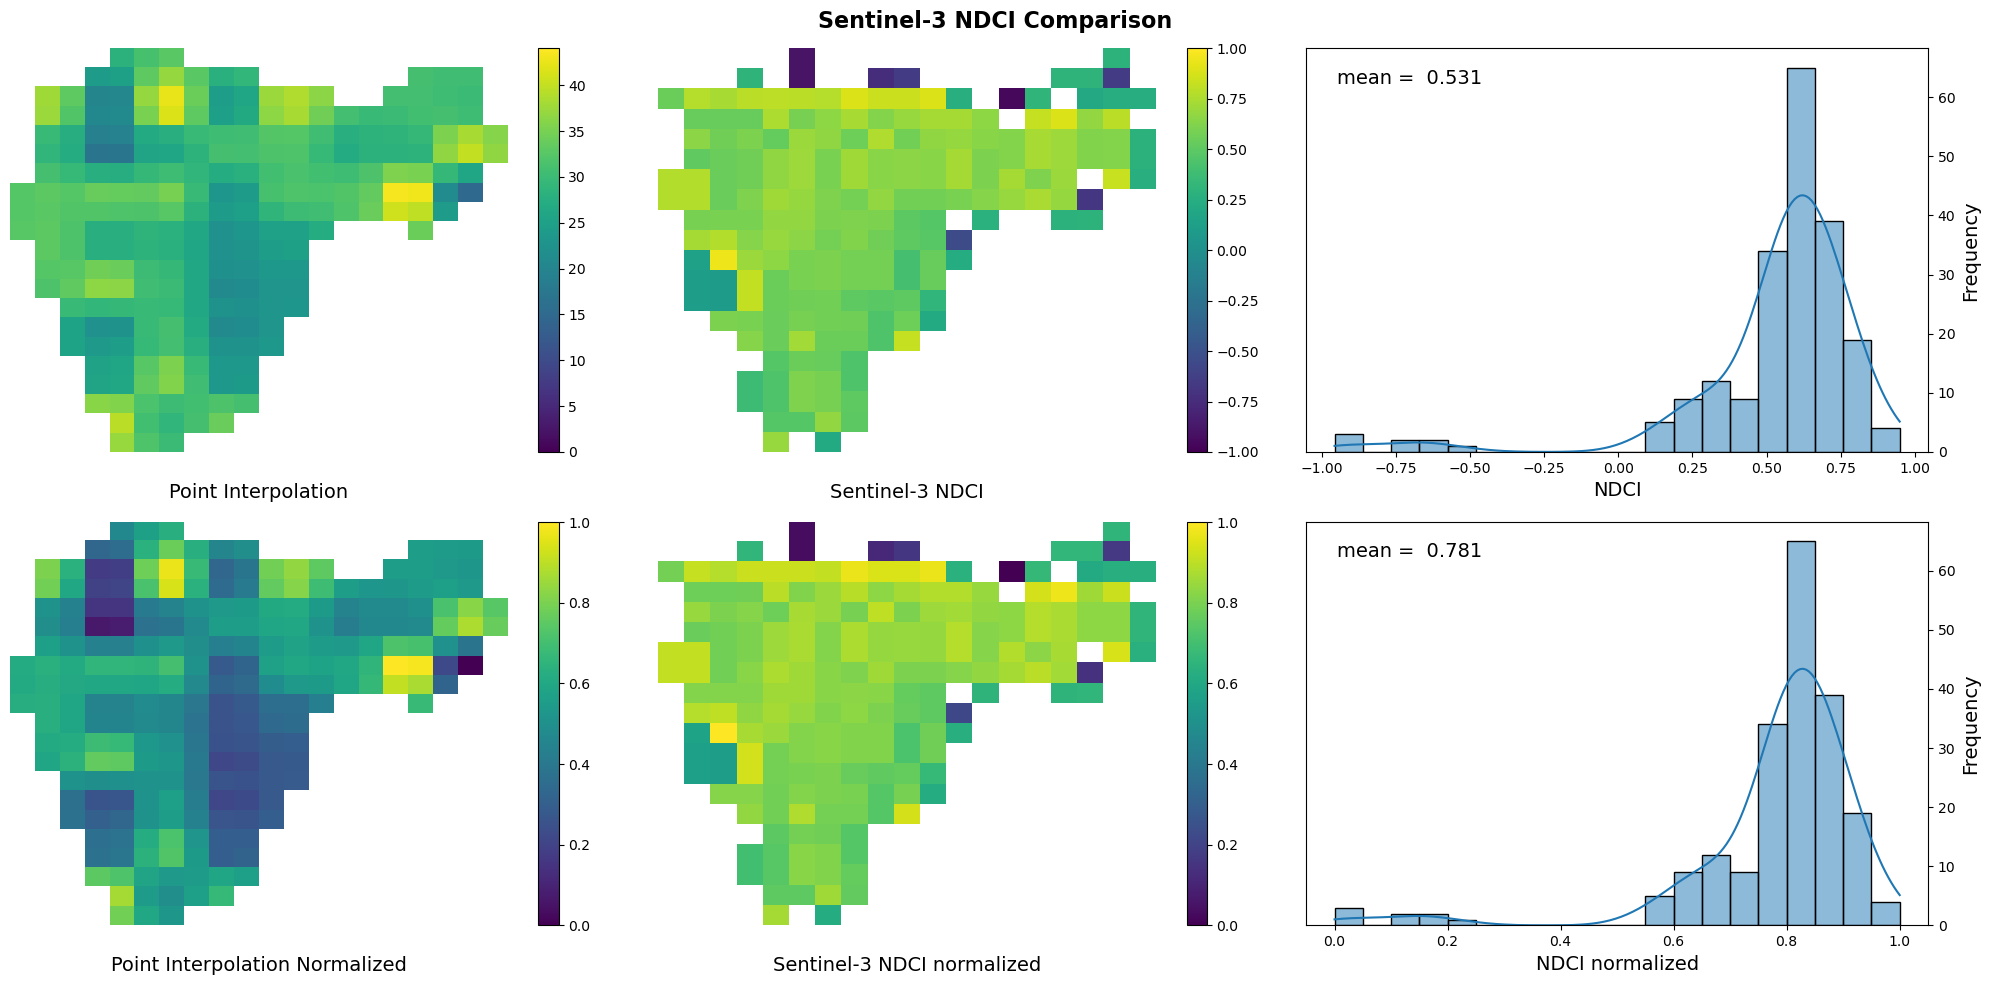

In [116]:
sat, norm = NDCI(S3, BSL, True, True)